In [9]:
import pandas as pd
import numpy as np

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt

In [10]:
train = pd.read_csv("../../Data/Price Prediction/train_pos.csv")
test = pd.read_csv("../../Data/Price Prediction/test_pos.csv")

train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

In [11]:
train.drop(['time','card_id','installments','days_of_week','holyday','is_canceled'],axis=1,inplace=True)
test.drop(['time','card_id','installments','days_of_week','holyday','is_canceled'],axis=1,inplace=True)

In [12]:
all_times = pd.date_range(test.date.min(), test.date.max(), freq = "D")

def row_col_change_sum(data, train_test):
    name_of_stores = data.store_id.unique()
    
    temp = data[['store_id', 'date', 'amount']].copy()
    temp = temp.groupby(['store_id', 'date'], as_index=False).sum()
    
    list_of_stores = pd.DataFrame(index = all_times)
    list_of_stores = list_of_stores.resample("7D").sum()
    
    for name in name_of_stores:
        temp1 = temp[temp['store_id']==name].groupby("date")[['amount']].sum()\
        .reindex(all_times).fillna(0).resample('7D').sum()
        # mean
        
        store_i =  "%s_store_%s" %(train_test, str(name))
        list_of_stores[store_i] = temp1
        
    return list_of_stores

In [13]:
train_stores_sum = row_col_change_sum(train, "train")
test_stores_sum = row_col_change_sum(test, "test")

In [14]:
def row_col_change_mean(data, train_test):
    name_of_stores = data.store_id.unique()
    
    temp = data[['store_id', 'date', 'amount']].copy()
    temp = temp.groupby(['store_id', 'date'], as_index=False).sum()
    
    list_of_stores = pd.DataFrame(index = all_times)
    list_of_stores = list_of_stores.resample("7D").sum()
    
    for name in name_of_stores:
        temp1 = temp[temp['store_id']==name].groupby("date")[['amount']].sum()\
        .reindex(all_times).fillna(0).resample('7D').mean()
        # mean
        
        store_i =  "%s_store_%s" %(train_test, str(name))
        list_of_stores[store_i] = temp1
        
    return list_of_stores

In [15]:
train_stores_mean = row_col_change_mean(train, "train")
test_stores_mean = row_col_change_mean(test, "test")

In [16]:
data_sum = pd.concat([train_stores_sum, test_stores_sum], axis=1)
data_mean = pd.concat([train_stores_mean, test_stores_mean], axis=1)

## Cluster

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [5]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

In [26]:
clf_sum = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_sum.T.values)
clf_mean = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_mean.T.values)

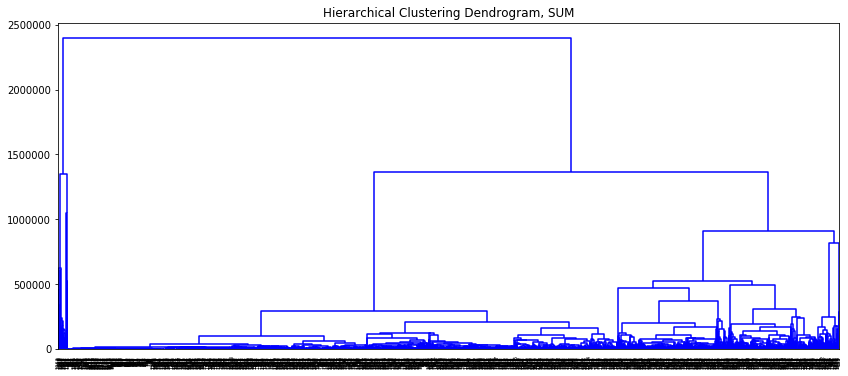

In [28]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, SUM')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf_sum, p=5, color_threshold = 110)
plt.show()

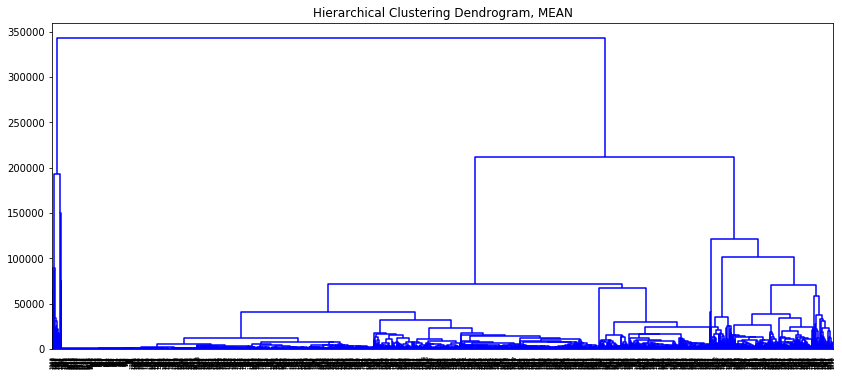

In [30]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, MEAN')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf_mean, p=5, color_threshold = 110)
plt.show()

### After scaling

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
# scaler = RobustScaler()

scaler.fit(data_sum)
data_sum = scaler.transform(data_sum)

scaler.fit(data_mean)
data_mean = scaler.transform(data_mean)

In [44]:
clf_sum = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_sum.T)
clf_mean = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_mean.T)

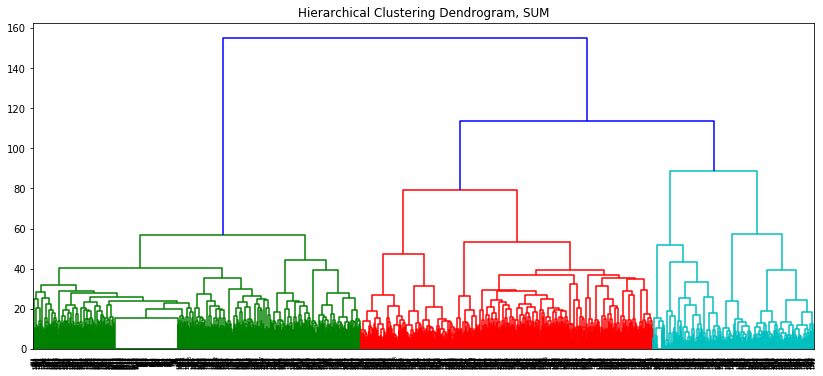

In [45]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, SUM')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf_sum, p=5, color_threshold = 110)
plt.show()

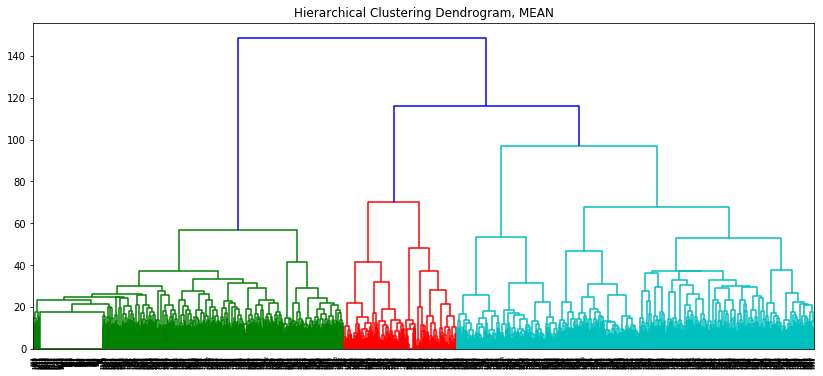

In [46]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, MEAN')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf_mean, p=5, color_threshold = 110)
plt.show()

In [47]:
# 아마도 scaling을 한 뒤 AgglomerativeClustering를 적용시키면 각 데이터가 가진 크기들(?)이 무시되는 것으로 보인다.

In [48]:
# scaling을 하지 않은 raw데이터를 사용

In [51]:
data_mean = pd.concat([train_stores_mean, test_stores_mean], axis=1)
clf_mean = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_mean.T.values)

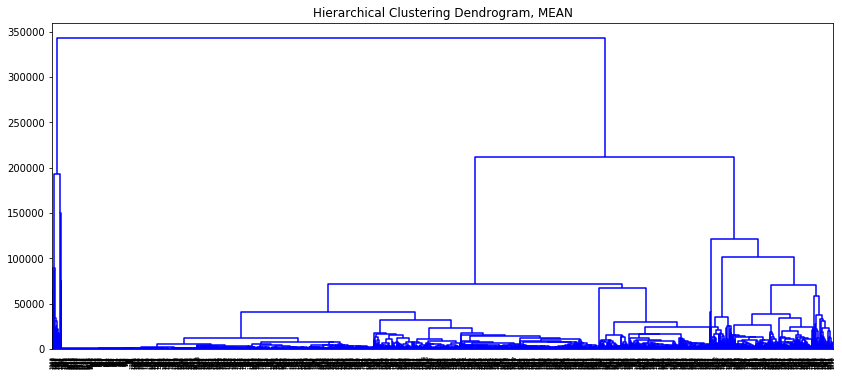

In [52]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, MEAN')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf_mean, p=5, color_threshold = 110)
plt.show()

In [55]:
# extract clusters from dendogram
clusters = fcluster(Z, 200000, criterion='distance')
# create a lookup table for series in a given cluster
stores_clustered = data_mean.T.reset_index()
stores_clustered["cluster"] = clusters
stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
stores_clustered = stores_clustered.groupby(['cluster', 'store_id']).mean()

In [56]:
stores_clustered

2016-08-01    2016-08-08   2016-08-15   2016-08-22  \
cluster store_id                                                               
1       test_store_148   4925.714286   5030.000000  2890.000000  7391.428571   
        test_store_153   6736.571429  10052.428571  7932.714286  7470.000000   
        test_store_34    3051.714286   3683.285714  4534.428571  4144.142857   
        test_store_38    2129.571429   4115.142857  3517.000000  3438.714286   
        test_store_80       0.000000      0.000000     0.000000     0.000000   
...                              ...           ...          ...          ...   
3       train_store_983  1779.285714   1163.571429   482.857143   131.428571   
        train_store_986   622.142857    628.571429   600.714286   841.428571   
        train_store_995     0.000000      0.000000     0.000000     0.000000   
        train_store_998   852.000000    922.285714  1357.571429  1130.714286   
        train_store_999   598.571429    180.000000     0.000000  1995.000000   

                           2016-08-29   2016-09-05   2016-09-12   2016-09-19  \
cluster store_id                                                               
1       test_store_148    6440.000000  4664.285714   841.428571  3945.000000   
        test_store_153   10356.000000  8554.000000  5808.000000  6973.714286   
        test_store_34     5770.285714  3920.000000  2359.571429  2534.857143   
        test_store_38     4849.142857  4135.714286  3961.142857  4696.428571   
        test_store_80        0.000000     0.000000     0.000000     0.000000   
...                               ...          ...          ...          ...   
3       train_store_983     89.285714   247.857143   198.571429   237.857143   
        train_store_986   1820.000000   420.714286   691.428571   235.714286   
        train_store_995      0.000000     0.000000     0.000000     0.000000   
        train_store_998   1381.428571  1209.285714  1340.142857   719.000000   
        train_store_999    682.571429     0.000000     0.000000  1595.857143   

                          2016-09-26   2016-10-03  ...    2018-01-22  \
cluster store_id                                   ...                 
1       test_store_148   3571.428571  3255.000000  ...   5487.142857   
        test_store_153   5922.285714  8401.142857  ...  13600.857143   
        test_store_34    2140.000000  4518.000000  ...   2290.285714   
        test_store_38    4515.285714  4777.142857  ...   3818.285714   
        test_store_80       0.000000     0.000000  ...  28565.000000   
...                              ...          ...  ...           ...   
3       train_store_983   132.142857     0.000000  ...   6243.571429   
        train_store_986  1663.571429   106.428571  ...    602.142857   
        train_store_995     0.000000     0.000000  ...   1579.285714   
        train_store_998  1385.428571  1130.428571  ...   1005.571429   
        train_store_999  1594.857143   537.857143  ...   1474.285714   

                           2018-01-29    2018-02-05    2018-02-12  \
cluster store_id                                                    
1       test_store_148    4440.714286   5261.428571   1315.714286   
        test_store_153   17012.000000  17906.142857  13608.571429   
        test_store_34     5511.857143   3244.285714   2721.142857   
        test_store_38     3995.428571   3912.142857   2029.142857   
        test_store_80    26076.571429  26901.714286  17662.142857   
...                               ...           ...           ...   
3       train_store_983      0.000000    157.857143     45.000000   
        train_store_986    507.142857   1136.428571    281.428571   
        train_store_995   1094.571429   1398.571429    545.714286   
        train_store_998    988.000000    992.142857    853.571429   
        train_store_999    480.714286      0.000000      0.000000   

                           2018-02-19    2018-02-26    2018-03-05  \
cluster store_id                        

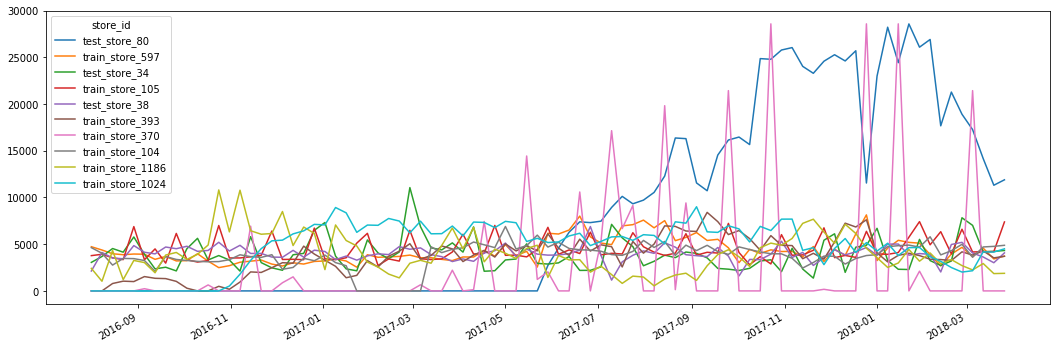

In [57]:
import random

# cluster 1
random.seed(1)
stores_clustered.loc[1].T.iloc[:, random.sample(range(stores_clustered.loc[1].shape[0]), 10)].plot(figsize = (18,6))

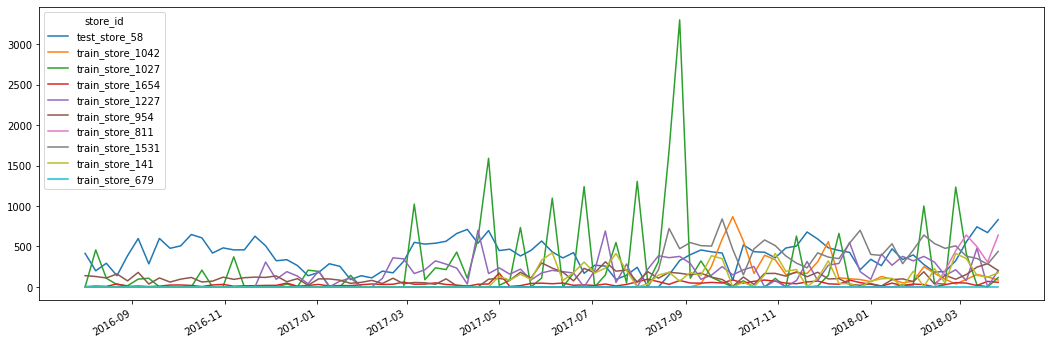

In [58]:
# cluster 2
random.seed(2)
stores_clustered.loc[2].T.iloc[:, random.sample(range(stores_clustered.loc[2].shape[0]), 10)].plot(figsize = (18,6))

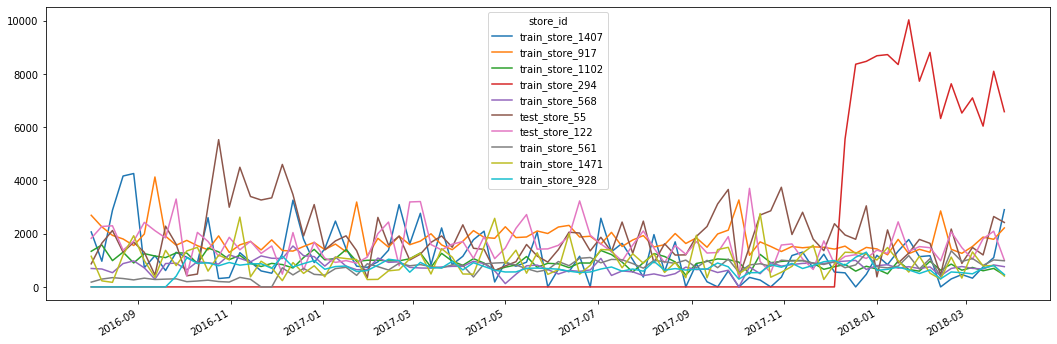

In [60]:
# cluster 3
random.seed(3)
stores_clustered.loc[3].T.iloc[:, random.sample(range(stores_clustered.loc[3].shape[0]), 10)].plot(figsize = (18,6))

In [18]:
# train을 정리할 필요가 있음

In [19]:
train_copy = train.copy()
train_copy['temp_date'] = train_copy.date
train_copy.set_index("date",inplace=True)

In [20]:
counter = 0
limit = 160
print("Before removing stores (due to limit): ", train.shape)

for x in range(train_copy['store_id'].max()+1): # iterating through each store_id
    if train_copy[train_copy['store_id']==x]['store_id'].count() >= limit:
        counter += 1
    else:
        # drop rows that has total 'store_id' less than limit
        train_copy = train_copy[train_copy.store_id != x]

print("Total # of stores that exceeds {} is {}".format(limit, counter))
print("After removing stores (due to limit): ", train_copy.shape)

Before removing stores (due to limit):  (3099969, 3)
Total # of stores that exceeds 160 is 1126
After removing stores (due to limit):  (3071674, 3)


In [21]:
# Now, the train set was checked for any stores that was out of business and removed them from the train set.
# If the store had no data within 5 days from 2018-07-31, it was 'assumed' to be closed.
# (2018-07-31 was the last date stores in train data was supposed to have)
from datetime import datetime

def keep_alive_store(df):
    
    store_id_list = df.store_id.unique() # list of train store_id
    yes, no = 0, 0 # yes: store has data within 5 days from 2018-07-31 / no: it doesn't

    t2 = datetime.strptime('2018-07-31 00:00:00', "%Y-%m-%d %H:%M:%S")

    for s in store_id_list:
        if str(df[df.store_id == s].iloc[-1]['temp_date']) == '2018-07-31 00:00:00':
            yes += 1
        else:
            # t1 is the last date of data the corresponding store_id has
            t1 = datetime.strptime(str(df[df.store_id == s].iloc[-1]['temp_date']), "%Y-%m-%d %H:%M:%S")
            difference = t2 - t1
            if difference.days <= 5:            
                yes +=1
            else:
                no +=1
                df = df[df.store_id != s] # remove stores that are 'assumed' closed
    print("# of train store open/out of business: ", yes, no)
    return df
    
train_copy = keep_alive_store(train_copy)

# of train store open/out of business:  1007 119


In [30]:
train = train_copy.groupby(["store_id", "temp_date"], as_index=False)[['amount']].sum()
train.rename(columns = {'temp_date' : 'date'}, inplace = True)

In [31]:
train_stores_mean = row_col_change_mean(train, "train")
test_stores_mean = row_col_change_mean(test, "test")

In [32]:
train_stores_sum = row_col_change_sum(train, "train")
test_stores_sum = row_col_change_sum(test, "test")

In [33]:
data_sum = pd.concat([train_stores_sum, test_stores_sum], axis=1)
data_mean = pd.concat([train_stores_mean, test_stores_mean], axis=1)

In [34]:
clf_sum = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_sum.T.values)
clf_mean = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_mean.T.values)

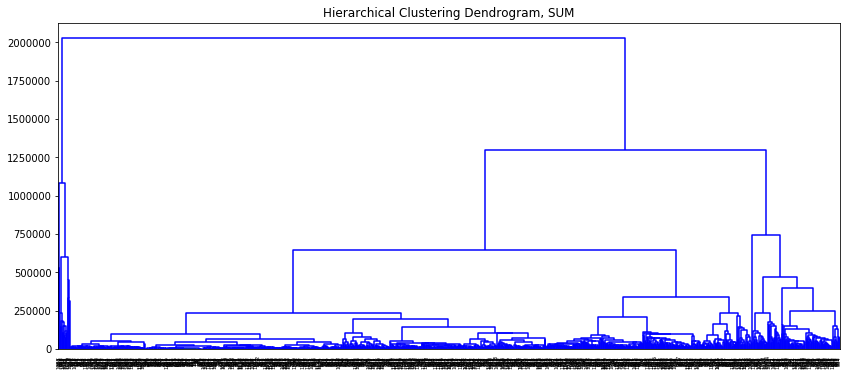

In [35]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, SUM')
# plot the top three levels of the dendrogram
Z_sum = plot_dendrogram(clf_sum, p=5, color_threshold = 110)
plt.show()

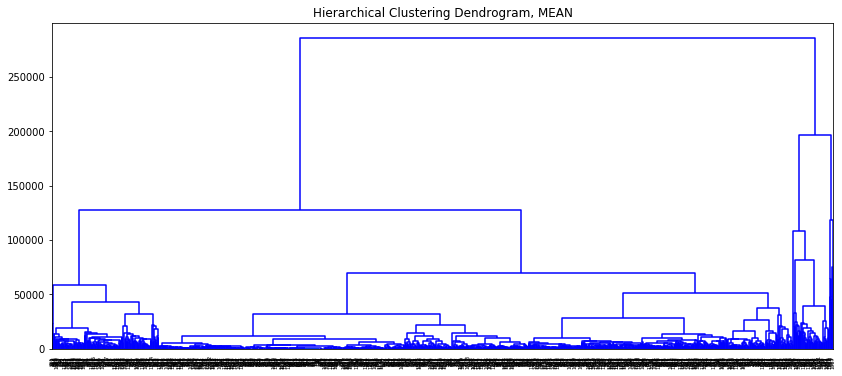

In [36]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, MEAN')
# plot the top three levels of the dendrogram
Z_mean = plot_dendrogram(clf_mean, p=5, color_threshold = 110)
plt.show()

In [37]:
# extract clusters from dendogram
clusters = fcluster(Z_sum, 750000, criterion='distance')
# create a lookup table for series in a given cluster
stores_clustered = data_sum.T.reset_index()
stores_clustered["cluster"] = clusters
stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
stores_clustered = stores_clustered.groupby(['cluster', 'store_id']).mean()

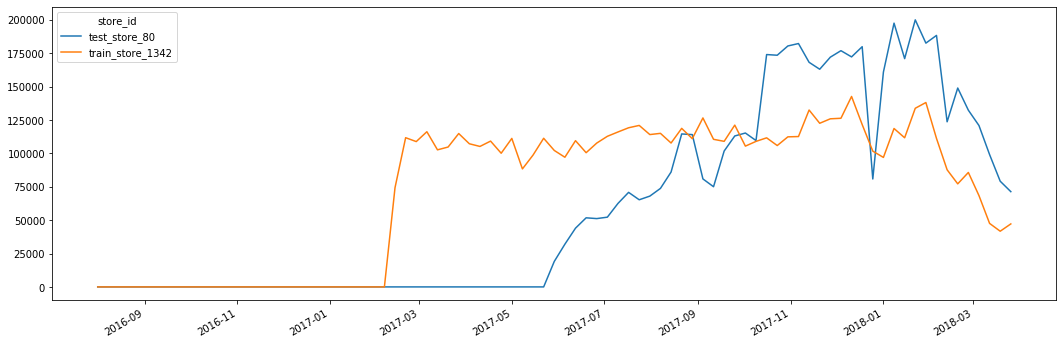

In [43]:
# cluster 1
import random

random.seed(1)
stores_clustered.loc[1].T.iloc[:, random.sample(range(stores_clustered.loc[1].shape[0]), 2)].plot(figsize = (18,6))

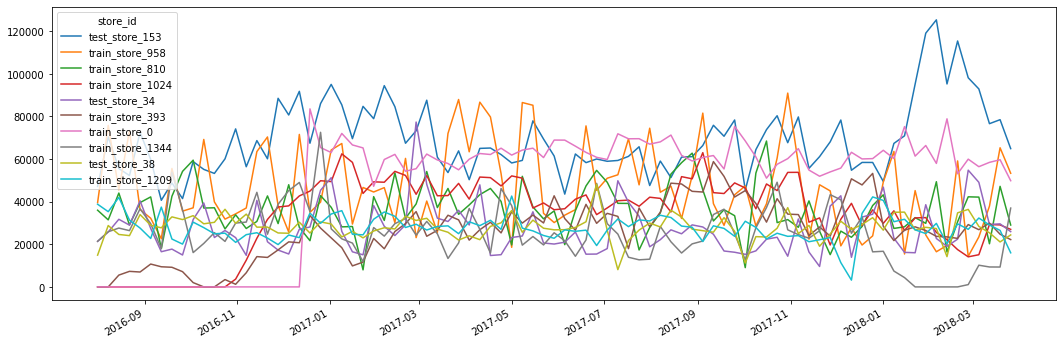

In [45]:
# cluster 2
random.seed(2)
stores_clustered.loc[2].T.iloc[:, random.sample(range(stores_clustered.loc[2].shape[0]), 10)].plot(figsize = (18,6))

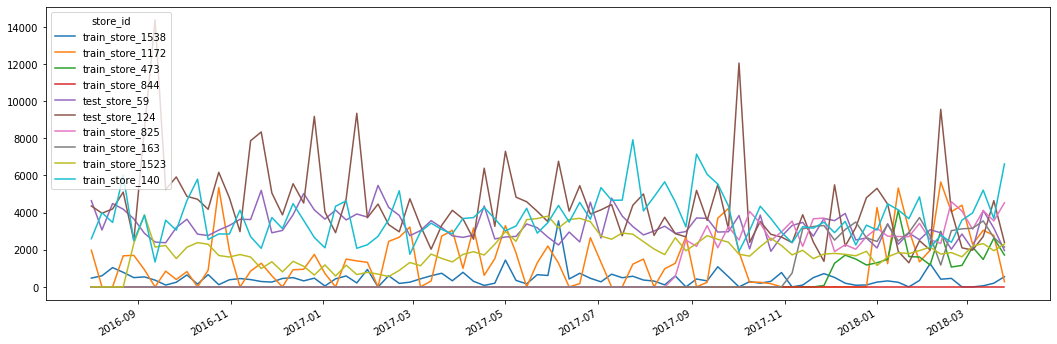

In [46]:
# cluster 3
random.seed(3)
stores_clustered.loc[3].T.iloc[:, random.sample(range(stores_clustered.loc[3].shape[0]), 10)].plot(figsize = (18,6))

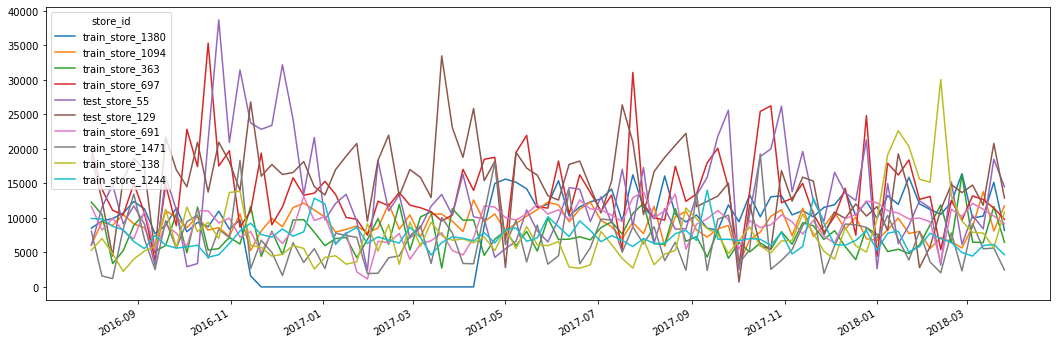

In [47]:
# cluster 4
random.seed(3)
stores_clustered.loc[4].T.iloc[:, random.sample(range(stores_clustered.loc[4].shape[0]), 10)].plot(figsize = (18,6))

In [48]:
# extract clusters from dendogram
clusters = fcluster(Z_sum, 500000, criterion='distance')
# create a lookup table for series in a given cluster
stores_clustered = data_mean.T.reset_index()
stores_clustered["cluster"] = clusters
stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
stores_clustered = stores_clustered.groupby(['cluster', 'store_id']).mean()

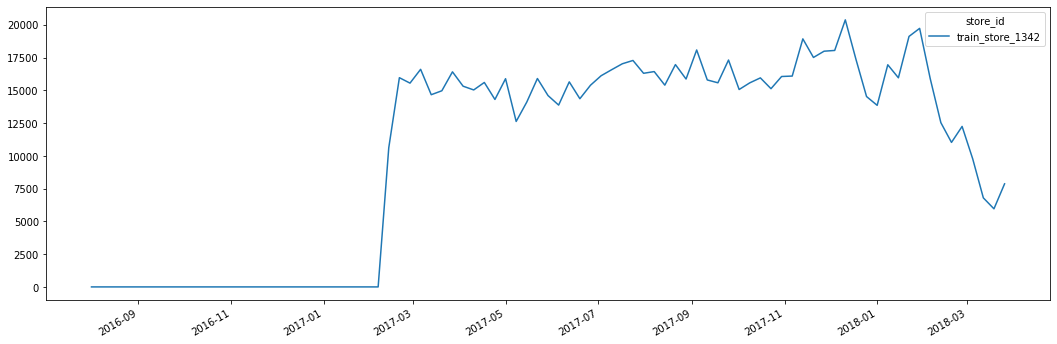

In [52]:
import random

# cluster 1
random.seed(1)
stores_clustered.loc[1].T.iloc[:, random.sample(range(stores_clustered.loc[1].shape[0]), 1)].plot(figsize = (18,6))

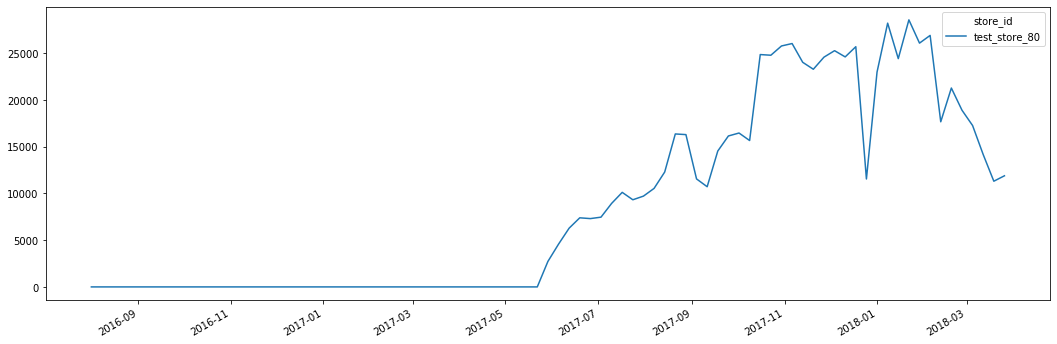

In [55]:
# cluster 2
random.seed(2)
stores_clustered.loc[2].T.iloc[:, random.sample(range(stores_clustered.loc[2].shape[0]), 1)].plot(figsize = (18,6))

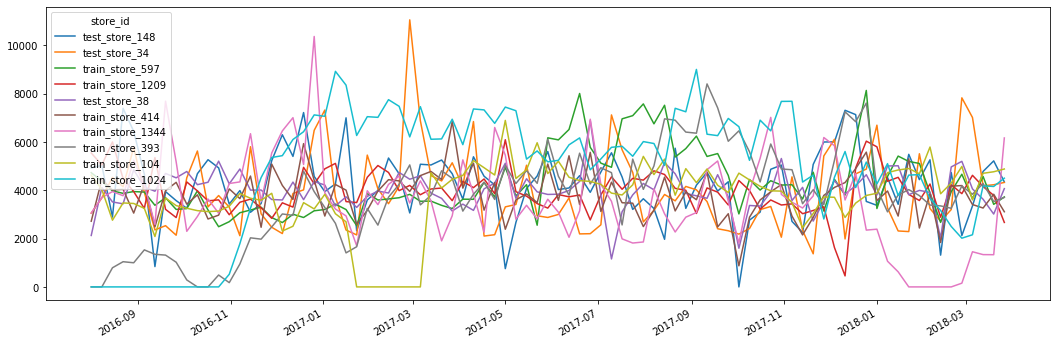

In [56]:
# cluster 3
random.seed(2)
stores_clustered.loc[3].T.iloc[:, random.sample(range(stores_clustered.loc[3].shape[0]), 10)].plot(figsize = (18,6))

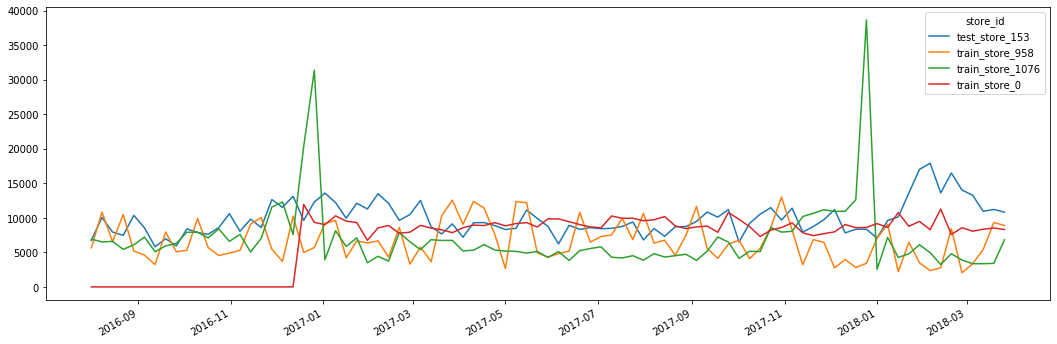

In [62]:
# cluster 4
random.seed(2)
stores_clustered.loc[4].T.iloc[:, random.sample(range(stores_clustered.loc[4].shape[0]), 4)].plot(figsize = (18,6))

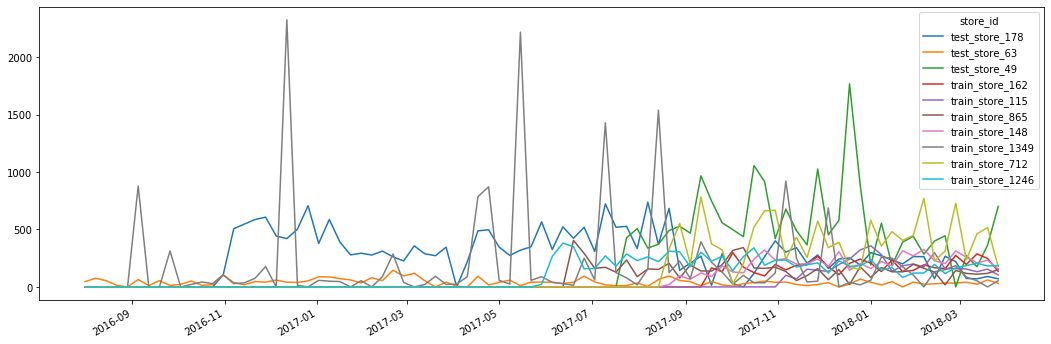

In [64]:
# cluster 5
random.seed(2)
stores_clustered.loc[5].T.iloc[:, random.sample(range(stores_clustered.loc[5].shape[0]), 10)].plot(figsize = (18,6))

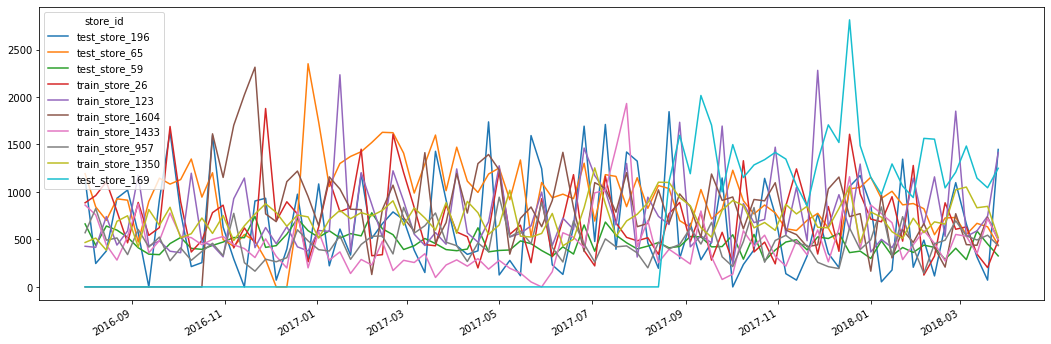

In [66]:
# cluster 6
random.seed(2)
stores_clustered.loc[6].T.iloc[:, random.sample(range(stores_clustered.loc[6].shape[0]), 10)].plot(figsize = (18,6))

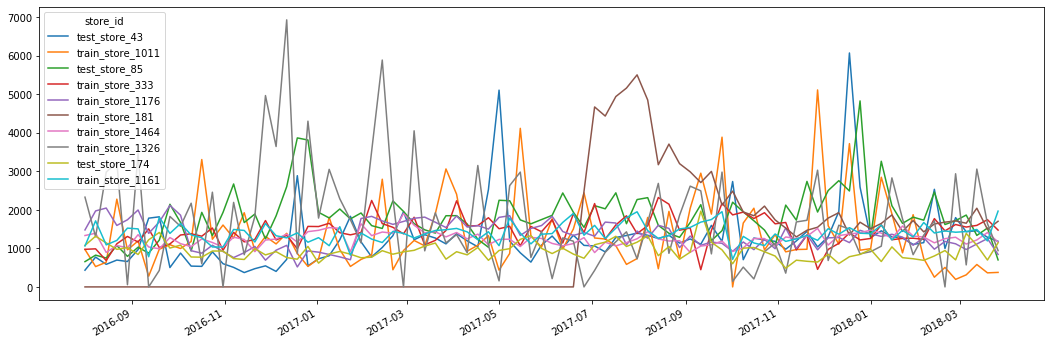

In [67]:
# cluster 7
random.seed(2)
stores_clustered.loc[7].T.iloc[:, random.sample(range(stores_clustered.loc[7].shape[0]), 10)].plot(figsize = (18,6))

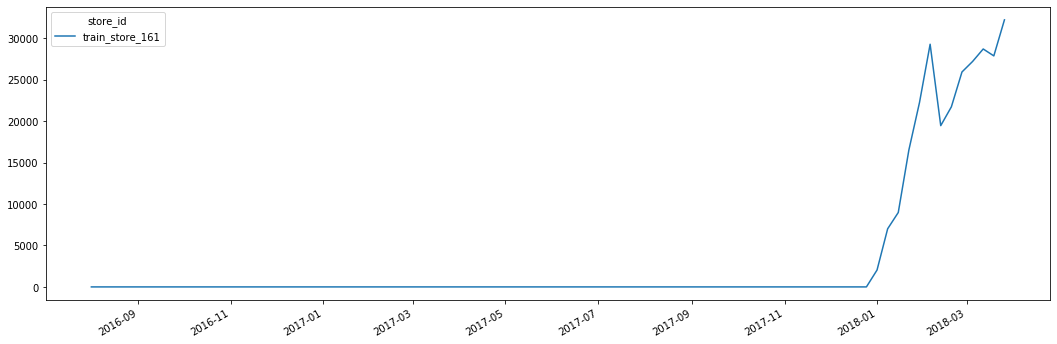

In [73]:
# cluster 8
random.seed(2)
stores_clustered.loc[8].T.iloc[:, random.sample(range(stores_clustered.loc[8].shape[0]), 1)].plot(figsize = (18,6))

In [ ]:
#  2017년도의 그래프만 분석

In [86]:
data_2017 = data_sum.loc["2017"]

In [87]:
clf_sum_2017 = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(data_2017.T.values)

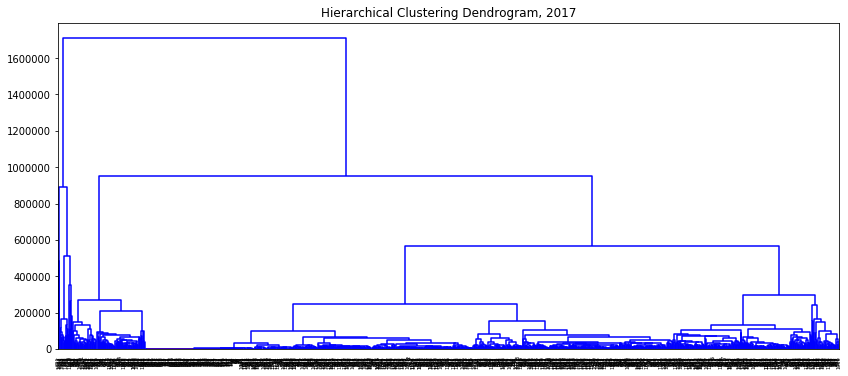

In [89]:
plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram, 2017')
# plot the top three levels of the dendrogram
Z_sum_2017 = plot_dendrogram(clf_sum_2017, p=5, color_threshold = 110)
plt.show()

In [105]:
# extract clusters from dendogram
clusters = fcluster(Z_sum_2017, 6, criterion='maxclust')
# create a lookup table for series in a given cluster
stores_clustered = data_2017.T.reset_index()
stores_clustered["cluster"] = clusters
stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
stores_clustered = stores_clustered.groupby(['cluster', 'store_id']).mean()

In [106]:
stores_clustered

2017-01-02  2017-01-09  2017-01-16  2017-01-23  \
cluster store_id                                                           
1       test_store_80            0.0         0.0         0.0         0.0   
        train_store_1342         0.0         0.0         0.0         0.0   
2       test_store_148       27620.0     29865.0     48990.0     16285.0   
        test_store_34        51244.0     26057.0     16482.0     15067.0   
        test_store_38        29531.0     23462.0     26102.0     23030.0   
...                              ...         ...         ...         ...   
6       train_store_979       2374.0      2579.0      4096.0      1903.0   
        train_store_986       2230.0      3255.0      3605.0       510.0   
        train_store_997       3138.0      5864.0      4368.0      4295.0   
        train_store_998       6013.0      5881.0      8967.0      7783.0   
        train_store_999          0.0       665.0      1350.0     12451.0   

                          2017-01-30  2017-02-06  2017-02-13  2017-02-20  \
cluster store_id                                                           
1       test_store_80            0.0         0.0         0.0         0.0   
        train_store_1342         0.0         0.0     74301.0    111724.0   
2       test_store_148       25185.0     27965.0     37340.0     32770.0   
        test_store_34        38190.0     28450.0     24110.0     29142.0   
        test_store_38        26238.0     27766.0     27204.0     33167.0   
...                              ...         ...         ...         ...   
6       train_store_979       2560.0      2602.0      1597.0      4925.0   
        train_store_986       5590.0     15205.0      3495.0      2130.0   
        train_store_997       4553.0      6287.0      4518.0      4756.0   
        train_store_998       5797.0      8343.0      9762.0      8082.0   
        train_store_999       5245.0      2350.0         0.0     12530.0   

                          2017-02-27  2017-03-06  ...  2017-10-23  2017-10-30  \
cluster store_id                                  ...                           
1       test_store_80            0.0         0.0  ...    173470.0    180401.0   
        train_store_1342    108812.0    116191.0  ...    105845.0    112358.0   
2       test_store_148       21435.0     35540.0  ...     34085.0     35300.0   
        test_store_34        77376.0     48141.0  ...     23312.0     14403.0   
        test_store_38        31197.0     32212.0  ...     27539.0     37202.0   
...                              ...         ...  ...         ...         ...   
6       train_store_979       4782.0      4164.0  ...      4826.0      3092.0   
        train_store_986       3110.0      3145.0  ...      6305.0      3945.0   
        train_store_997       4468.0      3789.0  ...      4231.0      2839.0   
        train_store_998       6516.0      8874.0  ...      7912.0      5280.0   
        train_store_999      11630.0      1275.0  ...     12495.0      5800.0   

                          2017-11-06  2017-11-13  2017-11-20  2017-11-27  \
cluster store_id                                                           
1       test_store_80       182222.0    168171.0    162977.0    172018.0   
        train_store_1342    112584.0    132448.0    122522.0    125866.0   
2       test_store_148       18989.0     15770.0     35500.0     41990.0   
        test_store_34        31881.0     16369.0      9593.0     37949.0   
        test_store_38        25023.0     28853.0     19078.0     24856.0   
...                              ...         ...         ...         ...   
6       train_store_979       2845.0      6259.0     14682.0      2814.0   
        train_store_986       2100.0      3425.0      9835.0      7825.0   
        train_store_997       4046.0      3119.0      1977.0      3600.0   
        train_store_998       8461.0      6579.0      8571.0      9270.0   
        train_store_999          0.0         0.0     10760.0      5550.0   

     

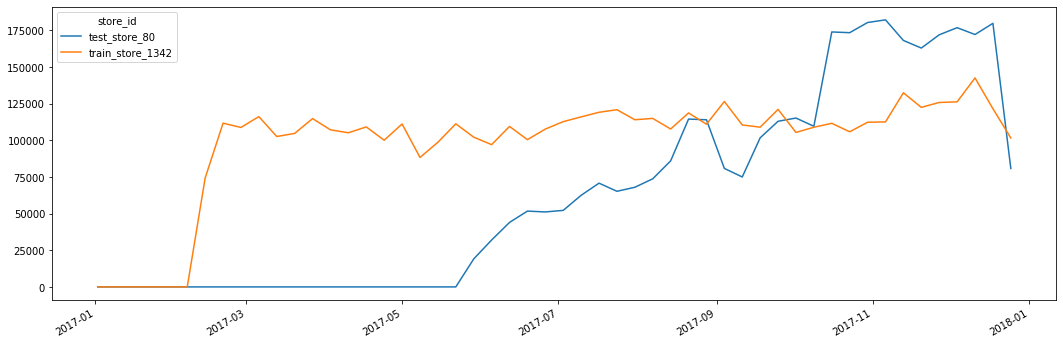

In [111]:
# cluster 1
import random

random.seed(1)
stores_clustered.loc[1].T.iloc[:, random.sample(range(stores_clustered.loc[1].shape[0]), 2)].plot(figsize = (18,6))

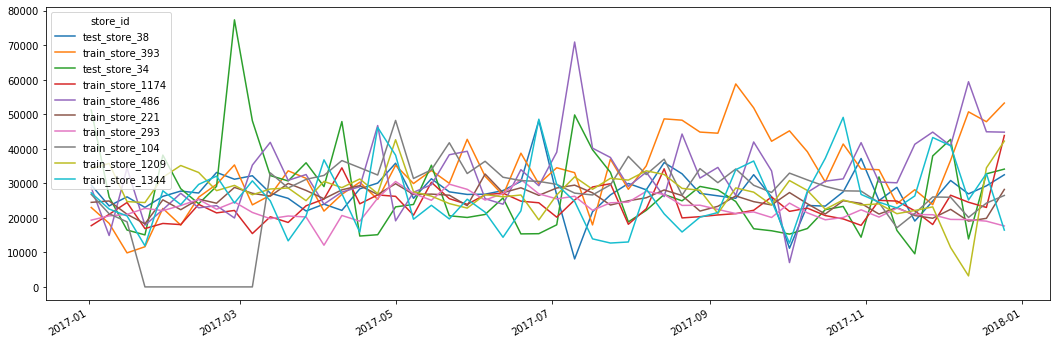

In [119]:
random.seed(1)
stores_clustered.loc[2].T.iloc[:, random.sample(range(stores_clustered.loc[2].shape[0]), 10)].plot(figsize = (18,6))

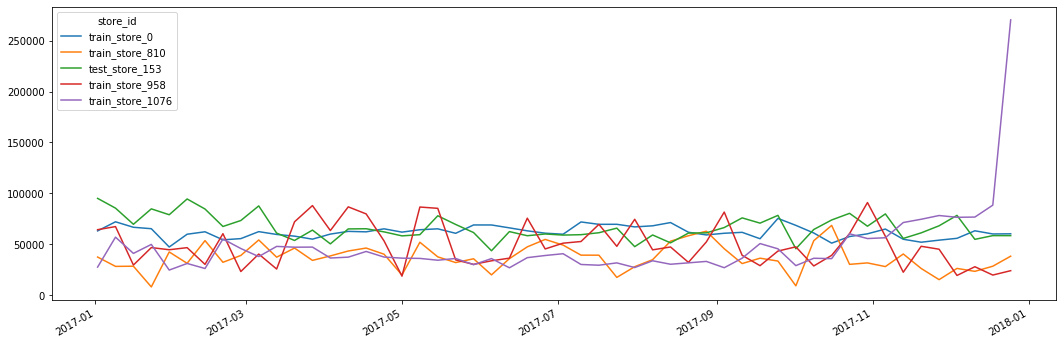

In [124]:
random.seed(1)
stores_clustered.loc[3].T.iloc[:, random.sample(range(stores_clustered.loc[3].shape[0]), 5)].plot(figsize = (18,6))

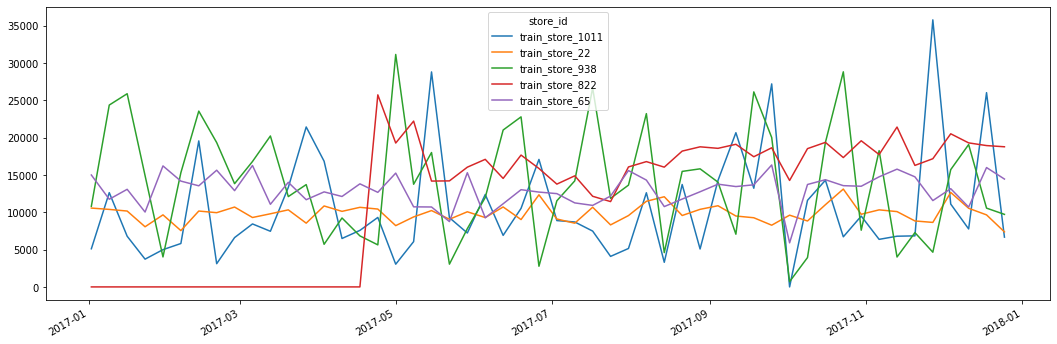

In [125]:
random.seed(1)
stores_clustered.loc[4].T.iloc[:, random.sample(range(stores_clustered.loc[4].shape[0]), 5)].plot(figsize = (18,6))

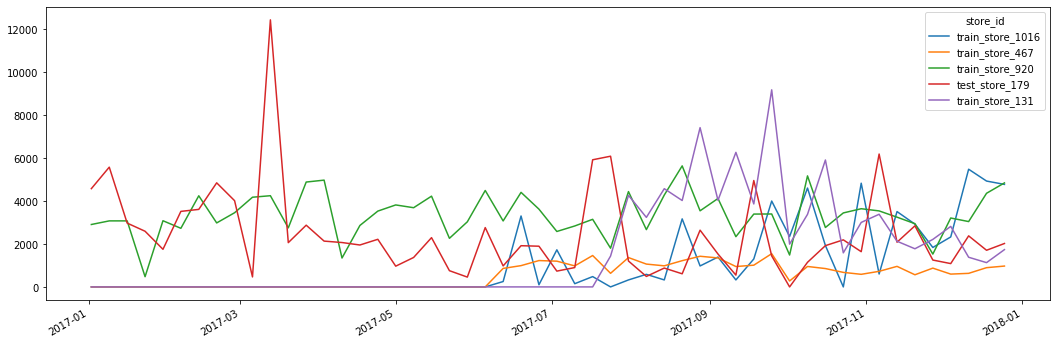

In [126]:
random.seed(1)
stores_clustered.loc[5].T.iloc[:, random.sample(range(stores_clustered.loc[5].shape[0]), 5)].plot(figsize = (18,6))

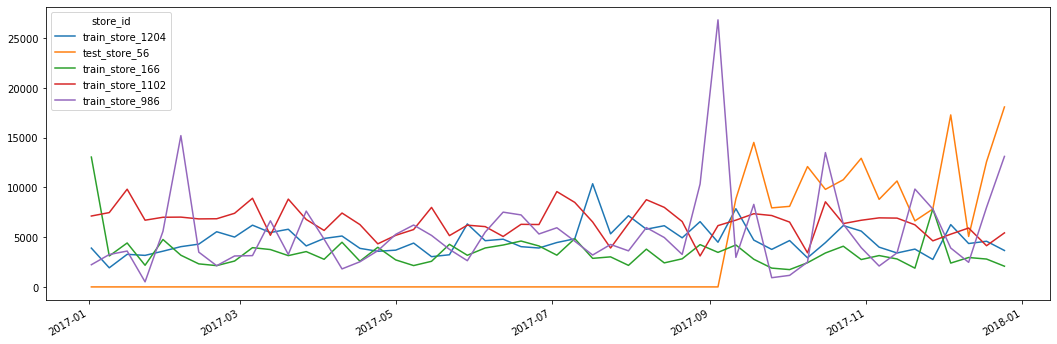

In [127]:
random.seed(1)
stores_clustered.loc[6].T.iloc[:, random.sample(range(stores_clustered.loc[6].shape[0]), 5)].plot(figsize = (18,6))

Text(0.5, 0, '2017 year, 7Days')

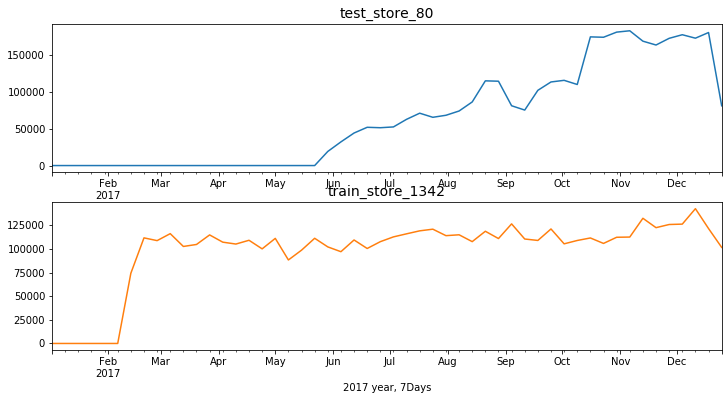

In [132]:
# show two series that look similar but are misaligned, for demonstration purposes
fig, [ax1,ax2] = plt.subplots(nrows = 2, figsize = (12,6))

data_2017["test_store_80"].plot(ax = ax1, color = "C0")
data_2017["train_store_1342"].plot(ax = ax2, color = "C1")
ax1.set_title("test_store_80", fontsize= 14)
ax2.set_title("train_store_1342", fontsize= 14)
ax1.set_xlabel("")
ax2.set_xlabel("2017 year, 7Days")

In [134]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



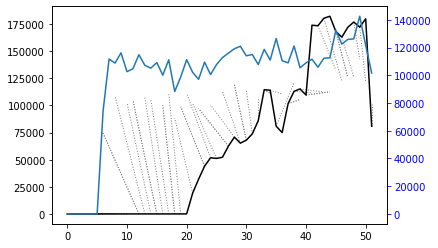

In [135]:
dtw(
     data_2017["test_store_80"],
    data_2017["train_store_1342"],
    keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=10)

In [143]:
stores_clustered.loc[2]

,2017-01-02,2017-01-09,2017-01-16,2017-01-23,2017-01-30,2017-02-06,2017-02-13,2017-02-20,2017-02-27,2017-03-06,...,2017-10-23,2017-10-30,2017-11-06,2017-11-13,2017-11-20,2017-11-27,2017-12-04,2017-12-11,2017-12-18,2017-12-25
store_id,,,,,,,,,,,,,,,,,,,,,
test_store_148,27620.0,29865.0,48990.0,16285.0,25185.0,27965.0,37340.0,32770.0,21435.0,35540.0,...,34085.0,35300.0,18989.0,15770.0,35500.0,41990.0,42020.0,51175.0,49920.0,24765.0
test_store_34,51244.0,26057.0,16482.0,15067.0,38190.0,28450.0,24110.0,29142.0,77376.0,48141.0,...,23312.0,14403.0,31881.0,16369.0,9593.0,37949.0,42765.0,13897.0,32767.0,34128.0
test_store_38,29531.0,23462.0,26102.0,23030.0,26238.0,27766.0,27204.0,33167.0,31197.0,32212.0,...,27539.0,37202.0,25023.0,28853.0,19078.0,24856.0,30834.0,26954.0,29287.0,32495.0
train_store_104,26824.0,21198.0,18860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27839.0,27759.0,24418.0,17140.0,21283.0,26059.0,25975.0,20128.0,24284.0,26498.0
train_store_1174,17743.0,21014.0,24459.0,16902.0,18386.0,18055.0,23916.0,21447.0,22157.0,15454.0,...,19701.0,17834.0,25075.0,24872.0,22043.0,18082.0,26564.0,24534.0,23022.0,43866.0
train_store_1209,34215.0,35789.0,24720.0,24441.0,31761.0,35174.0,33157.0,27893.0,29415.0,26708.0,...,25190.0,23732.0,24063.0,21211.0,22145.0,23194.0,11412.0,3191.0,34500.0,42235.0
train_store_1344,27259.0,22561.0,20567.0,11918.0,27853.0,23843.0,29691.0,32113.0,24296.0,30729.0,...,49127.0,26800.0,24538.0,22862.0,26363.0,43287.0,40901.0,25190.0,32844.0,16461.0
train_store_221,24497.0,24899.0,21048.0,18286.0,25229.0,22369.0,25425.0,24246.0,28829.0,27128.0,...,24977.0,24196.0,21108.0,22999.0,20686.0,19891.0,22477.0,19059.0,19872.0,28244.0
train_store_293,19348.0,20578.0,21010.0,22762.0,22105.0,23577.0,25351.0,22509.0,24600.0,21574.0,...,20112.0,22344.0,20237.0,22795.0,20981.0,20916.0,19558.0,19506.0,19045.0,17662.0


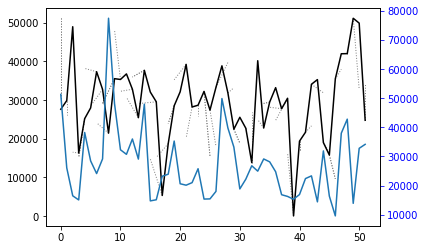

In [147]:
dtw(
    data_2017["test_store_148"],
    data_2017["test_store_34"],
    keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=10)

In [155]:
stores_clustered

2017-01-02  2017-01-09  2017-01-16  2017-01-23  \
cluster store_id                                                           
1       test_store_80            0.0         0.0         0.0         0.0   
        train_store_1342         0.0         0.0         0.0         0.0   
2       test_store_148       27620.0     29865.0     48990.0     16285.0   
        test_store_34        51244.0     26057.0     16482.0     15067.0   
        test_store_38        29531.0     23462.0     26102.0     23030.0   
...                              ...         ...         ...         ...   
6       train_store_979       2374.0      2579.0      4096.0      1903.0   
        train_store_986       2230.0      3255.0      3605.0       510.0   
        train_store_997       3138.0      5864.0      4368.0      4295.0   
        train_store_998       6013.0      5881.0      8967.0      7783.0   
        train_store_999          0.0       665.0      1350.0     12451.0   

                          2017-01-30  2017-02-06  2017-02-13  2017-02-20  \
cluster store_id                                                           
1       test_store_80            0.0         0.0         0.0         0.0   
        train_store_1342         0.0         0.0     74301.0    111724.0   
2       test_store_148       25185.0     27965.0     37340.0     32770.0   
        test_store_34        38190.0     28450.0     24110.0     29142.0   
        test_store_38        26238.0     27766.0     27204.0     33167.0   
...                              ...         ...         ...         ...   
6       train_store_979       2560.0      2602.0      1597.0      4925.0   
        train_store_986       5590.0     15205.0      3495.0      2130.0   
        train_store_997       4553.0      6287.0      4518.0      4756.0   
        train_store_998       5797.0      8343.0      9762.0      8082.0   
        train_store_999       5245.0      2350.0         0.0     12530.0   

                          2017-02-27  2017-03-06  ...  2017-10-23  2017-10-30  \
cluster store_id                                  ...                           
1       test_store_80            0.0         0.0  ...    173470.0    180401.0   
        train_store_1342    108812.0    116191.0  ...    105845.0    112358.0   
2       test_store_148       21435.0     35540.0  ...     34085.0     35300.0   
        test_store_34        77376.0     48141.0  ...     23312.0     14403.0   
        test_store_38        31197.0     32212.0  ...     27539.0     37202.0   
...                              ...         ...  ...         ...         ...   
6       train_store_979       4782.0      4164.0  ...      4826.0      3092.0   
        train_store_986       3110.0      3145.0  ...      6305.0      3945.0   
        train_store_997       4468.0      3789.0  ...      4231.0      2839.0   
        train_store_998       6516.0      8874.0  ...      7912.0      5280.0   
        train_store_999      11630.0      1275.0  ...     12495.0      5800.0   

                          2017-11-06  2017-11-13  2017-11-20  2017-11-27  \
cluster store_id                                                           
1       test_store_80       182222.0    168171.0    162977.0    172018.0   
        train_store_1342    112584.0    132448.0    122522.0    125866.0   
2       test_store_148       18989.0     15770.0     35500.0     41990.0   
        test_store_34        31881.0     16369.0      9593.0     37949.0   
        test_store_38        25023.0     28853.0     19078.0     24856.0   
...                              ...         ...         ...         ...   
6       train_store_979       2845.0      6259.0     14682.0      2814.0   
        train_store_986       2100.0      3425.0      9835.0      7825.0   
        train_store_997       4046.0      3119.0      1977.0      3600.0   
        train_store_998       8461.0      6579.0      8571.0      9270.0   
        train_store_999          0.0         0.0     10760.0      5550.0   

     

In [169]:
def clustered_store_id(cluster_number):
    cluster_num = stores_clustered.loc[cluster_number]
    num = len(cluster_num)
    
    train_index = []
    test_index = []
    
    for j in range(0,num):
        name = cluster_num.index[j].split('_')
        if name[0] == 'train':
            train_index.append(name[2])
        else:
            test_index.append(name[2])
            
    df_train = pd.DataFrame({"train_id": train_index})
    df_test = pd.DataFrame({"test_id": test_index})
    return df_train, df_test
    

In [170]:
cluster_train_1, cluster_test_1 = clustered_store_id(1)
cluster_train_2, cluster_test_2 = clustered_store_id(2)
cluster_train_3, cluster_test_3 = clustered_store_id(3)
cluster_train_4, cluster_test_4 = clustered_store_id(4)
cluster_train_5, cluster_test_5 = clustered_store_id(5)
cluster_train_6, cluster_test_6 = clustered_store_id(6)